In [ ]:
import pandas as pd
import sklearn.metrics as met
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Binary Prediction of Gentrified Tracts in Melbourne

This noteboke containes the Feed-Forward Neural Networks (FFNN) used to model a binary classification problem about transit-induced gentrification in Melbourne. There are two gentrification periods to be analysed: 2006-2016 and 2011-2016. The training labels were obtained following Freeman's 5-step definition of gentrified areas.

The evaluation process is centered around Recall. In order to do wo while preventing the models from predicting all instances as positive, the main metric is F2 with recall being twice as aimportant as precision.

# Table of Contents

1. [Models for 2006-2016 Gentrification Period](#2006_2016_model)

2. [Models for 2011-2016 Gentrification Period](#2011_2016_model)

In [ ]:
# Function to print evaluation metrics

def print_metrics(predictions, y_test, name='model'):
    f2 = met.fbeta_score(y_test, predictions, beta=2)
    print('F2: {}'.format(round(f2,3)))
    recall = met.recall_score(y_test, predictions)
    print('Recall: {}'.format(round(recall,3)))
    precision = met.precision_score(y_test, predictions)
    print('Precision: {}'.format(round(precision,3)))
    acc = met.accuracy_score(y_test, predictions)
    print('Accuracy: {}'.format(round(acc,3)))

In [ ]:
# Function to plot Precision-Recall Curve

def plot_PRC(y_test, y_prob, name='model'):
    precision, recall, thresholds = met.precision_recall_curve(y_test, y_prob)
    pr_auc = met.auc(recall, precision)
    print('The PR-AUC: ' + str(round(pr_auc,3)))
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==True]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim(0,1)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [ ]:
# Plot results used to calculate the grand mean of metrics

def plot_series(met_list, name='metric'):
  mean = statistics.mean(met_list)
  plt.plot([0, len(met_list)], [mean, mean], linestyle='--', label='mean')
  plt.plot(met_list, label='series')
  plt.xlabel('series')
  plt.ylabel(name)
  plt.ylim(0,1)
  plt.show

  print('The variance is: ' + str(np.var(met_list)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  2006-2016 Gentrification Period <a name='2006_2016_model'></a>

In [ ]:
reduced_06_16 = pd.read_csv('drive/MyDrive/dataset_reduced_06_16.csv')
complete_06_16 = pd.read_csv('drive/MyDrive/dataset_complete_06_16.csv')

In [ ]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_06R = reduced_06_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06R[X_06R.columns] = scaler_R.fit_transform(X_06R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_06C = complete_06_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06C[X_06C.columns] = scaler_C.fit_transform(X_06C)

# Split dataset
X_06R_select, X_06R_test, y_06R_select, y_06R_test = train_test_split(X_06R,
                                                                      reduced_06_16['Gentrified_06_16'], 
                                                                      test_size=0.10,
                                                                      random_state=0)
X_06R_train, X_06R_val, y_06R_train, y_06R_val = train_test_split(X_06R_select,
                                                                  y_06R_select, 
                                                                  test_size=0.111,
                                                                  random_state=0)

X_06C_select, X_06C_test, y_06C_select, y_06C_test = train_test_split(X_06C,
                                                                      complete_06_16['Gentrified_06_16'], 
                                                                      test_size=0.10,
                                                                      random_state=0)
X_06C_train, X_06C_val, y_06C_train, y_06C_val = train_test_split(X_06C_select,
                                                                  y_06C_select, 
                                                                  test_size=0.111,
                                                                  random_state=0)

In [ ]:
# Class wights fixed to the proportion of positives and negtives

y_06 = reduced_06_16['Gentrified_06_16']
int_ratio_06 = round(100*len(y_06[y_06 == True])/ len(y_06))

cw_06 = {False: int_ratio_06, True: 100-int_ratio_06}

In [ ]:
# metrics

metrics = [tf.keras.metrics.Recall(),
           tf.keras.metrics.Accuracy(),
           tf.keras.metrics.Precision(),
           ]

FFNN trained and configured with a reduced number of demographic features.

F2: 0.7304919664129482
recall: 0.8234567901234567
precision: 0.5361547798861023
accuracy: 0.8702947845804988
The variance is: 0.0013030428853787466


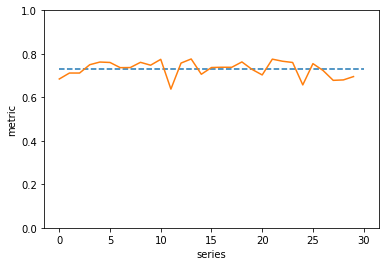

In [ ]:
model = Sequential()
model.add(Dense(105, input_dim = X_06R_train.shape[1], activation='selu'))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(105, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision_06R = []
acc_06R = []
f2_06R = []
recall_06R = []
for i in range(30):

  history = model.fit(x=X_06R_select, 
                    y=y_06R_select, 
                    epochs=50,
                    batch_size=2000,
                    class_weight=cw_06,
                    verbose=0)
                    
  f2_06R.append(met.fbeta_score(y_06R_test, model.predict(X_06R_test).round(), beta=2))
  recall_06R.append(met.recall_score(y_06R_test, model.predict(X_06R_test).round()))
  precision_06R.append(met.precision_score(y_06R_test, model.predict(X_06R_test).round()))
  acc_06R.append(met.accuracy_score(y_06R_test, model.predict(X_06R_test).round()))

print('F2: ' + str(statistics.mean(f2_06R)))
print('recall: ' + str(statistics.mean(recall_06R)))
print('precision: ' + str(statistics.mean(precision_06R)))
print('accuracy: ' + str(statistics.mean(acc_06R)))

plot_series(f2_06R)

FFNN trained and configured with all demographic features.

F2: 0.6914941966678579
recall: 0.7054320987654321
precision: 0.6538716101429535
accuracy: 0.9098801425332037
The variance is: 0.00121374201738395


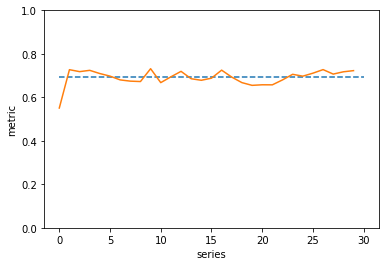

In [ ]:
model = Sequential()
model.add(Dense(477, input_dim = X_06C_train.shape[1], activation='selu'))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(477, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision_06C = []
acc_06C = []
f2_06C = []
recall_06C = []
for i in range(30):

  history = model.fit(x=X_06C_train, 
                    y=y_06C_train, 
                    validation_data=(X_06C_val, y_06C_val),
                    epochs=50,
                    batch_size=2000,
                    class_weight=cw_06,
                    verbose=0,
                    )
                    
  f2_06C.append(met.fbeta_score(y_06C_test, model.predict(X_06C_test).round(), beta=2))
  recall_06C.append(met.recall_score(y_06C_test, model.predict(X_06C_test).round()))
  precision_06C.append(met.precision_score(y_06C_test, model.predict(X_06C_test).round()))
  acc_06C.append(met.accuracy_score(y_06C_test, model.predict(X_06C_test).round()))

print('F2: ' + str(statistics.mean(f2_06C)))
print('recall: ' + str(statistics.mean(recall_06C)))
print('precision: ' + str(statistics.mean(precision_06C)))
print('accuracy: ' + str(statistics.mean(acc_06C)))

plot_series(f2_06C)

The model trained and configured with the a reduced number of demographic features performes better than the complete version, just as it happened with the machine learning models. Overall, the performance regarding F2 and Recall is superior to the baseline (Logistic Regression) and SVM.

##  2011-2016 Gentrification Period <a name='2011_2016_model'></a>

In [ ]:
reduced_11_16 = pd.read_csv('drive/MyDrive/dataset_reduced_11_16.csv')
complete_11_16 = pd.read_csv('drive/MyDrive/dataset_complete_11_16.csv')

In [ ]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_11R = reduced_11_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11R[X_11R.columns] = scaler_R.fit_transform(X_11R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_11C = complete_11_16.drop(columns = ['Unnamed: 0','SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11C[X_11C.columns] = scaler_C.fit_transform(X_11C)

# Split dataset
X_11R_select, X_11R_test, y_11R_select, y_11R_test = train_test_split(X_11R,
                                                                    reduced_11_16['Gentrified_11_16'], 
                                                                    test_size=0.10,
                                                                    random_state=0)
X_11R_train, X_11R_val, y_11R_train, y_11R_val = train_test_split(X_11R_select,
                                                                    y_11R_select, 
                                                                    test_size=0.111,
                                                                  random_state=0)

X_11C_select, X_11C_test, y_11C_select, y_11C_test = train_test_split(X_11C,
                                                                    complete_11_16['Gentrified_11_16'], 
                                                                    test_size=0.10,
                                                                    random_state=0)
X_11C_train, X_11C_val, y_11C_train, y_11C_val = train_test_split(X_11C_select,
                                                                    y_11C_select, 
                                                                    test_size=0.111,
                                                                  random_state=0)

In [ ]:
# Class wights fixed to the proportion of positives and negtives

y_11 = reduced_11_16['Gentrified_11_16']
int_ratio_11 = round(100*len(y_11[y_11 == True])/ len(y_11))

cw_11 = {False: int_ratio_11, True: 100-int_ratio_11}

FFNN trained and configured with a reduced number of demographic features.

F2: 0.5616289694359605
recall: 0.6676923076923077
precision: 0.3684215013802628
accuracy: 0.8043083900226757
The variance is: 0.0002086905406897102


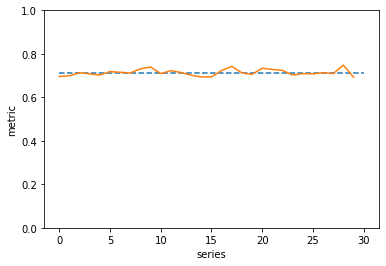

In [ ]:
model = Sequential()
model.add(Dense(105, input_dim = X_11R_train.shape[1], activation='selu'))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(105, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(105, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision_11R = []
acc_11R = []
f2_11R = []
recall_11R = []
for i in range(10):

  history = model.fit(x=X_11R_select, 
                    y=y_11R_select, 
                    epochs=50,
                    batch_size=2000,
                    class_weight=cw_11,
                    verbose=0)
                    
  f2_11R.append(met.fbeta_score(y_11R_test, model.predict(X_11R_test).round(), beta=2))
  recall_11R.append(met.recall_score(y_11R_test, model.predict(X_11R_test).round()))
  precision_11R.append(met.precision_score(y_11R_test, model.predict(X_11R_test).round()))
  acc_11R.append(met.accuracy_score(y_11R_test, model.predict(X_11R_test).round()))

print('F2: ' + str(statistics.mean(f2_11R)))
print('recall: ' + str(statistics.mean(recall_11R)))
print('precision: ' + str(statistics.mean(precision_11R)))
print('accuracy: ' + str(statistics.mean(acc_11R)))

plot_series(f2_11R)

FFNN trained and configured with all demographic features.

F2: 0.3322427535533208
recall: 0.34690265486725663
precision: 0.2949149525489095
accuracy: 0.836767087787496
The variance is: 0.0032314725316097523


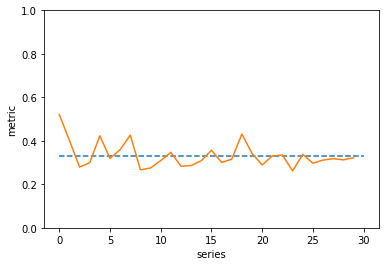

In [ ]:
model = Sequential()
model.add(Dense(477, input_dim = X_11C_train.shape[1], activation='selu'))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(477, activation='selu'))
model.add(Dropout(0.4))
model.add(Dense(477, activation='selu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=metrics,)

precision_11C = []
acc_11C = []
f2_11C = []
recall_11C = []
for i in range(30):

  history = model.fit(x=X_11C_train, 
                    y=y_11C_train, 
                    validation_data=(X_11C_val, y_11C_val),
                    epochs=50,
                    batch_size=2000,
                    class_weight=cw_11,
                    verbose=0,
                    )
                    
  f2_11C.append(met.fbeta_score(y_11C_test, model.predict(X_11C_test).round(), beta=2))
  recall_11C.append(met.recall_score(y_11C_test, model.predict(X_11C_test).round()))
  precision_11C.append(met.precision_score(y_11C_test, model.predict(X_11C_test).round()))
  acc_11C.append(met.accuracy_score(y_11C_test, model.predict(X_11C_test).round()))

print('F2: ' + str(statistics.mean(f2_11C)))
print('recall: ' + str(statistics.mean(recall_11C)))
print('precision: ' + str(statistics.mean(precision_11C)))
print('accuracy: ' + str(statistics.mean(acc_11C)))

plot_series(f2_11C)

Just like in the off-the-shelf machine learning models, the gentrification period between 2011 and 2016 shows a poorer performance.